In [1]:
import pandas as pd
import numpy as np

import os

import time

from brendapy import BrendaParser
from brendapy.console import console

from tqdm import tqdm

import glob

import json

import requests

import missingno as msno

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import RDConfig

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqIO.FastaIO import FastaWriter

from sgt import SGT

import pandarallel

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

Taxonomy loaded in 5.99 seconds.

# Exploring Size and Shape of BRENDA Data

In [2]:
input_df = pd.read_csv('all_data_combined_clean.tsv', sep='\t')

In [3]:
print(f"there are {input_df['uniprot_ids'].nunique()} unique proteins and {input_df['CID'].nunique()} unique compounds")

there are 4147 unique proteins and 673 unique compounds


In [4]:
sub_df = input_df[['uniprot_ids','CID']]
sub_df['value'] = 1

<ipython-input-4-4c23df4cc242>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['value'] = 1


In [5]:
pivot_df_m_n = pd.pivot_table(sub_df, values='value', index='CID', columns='uniprot_ids', aggfunc='sum')

In [6]:
pivot_df_n_m = pd.pivot_table(sub_df, values='value', index='uniprot_ids', columns='CID', aggfunc='sum')

## Sparsity

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

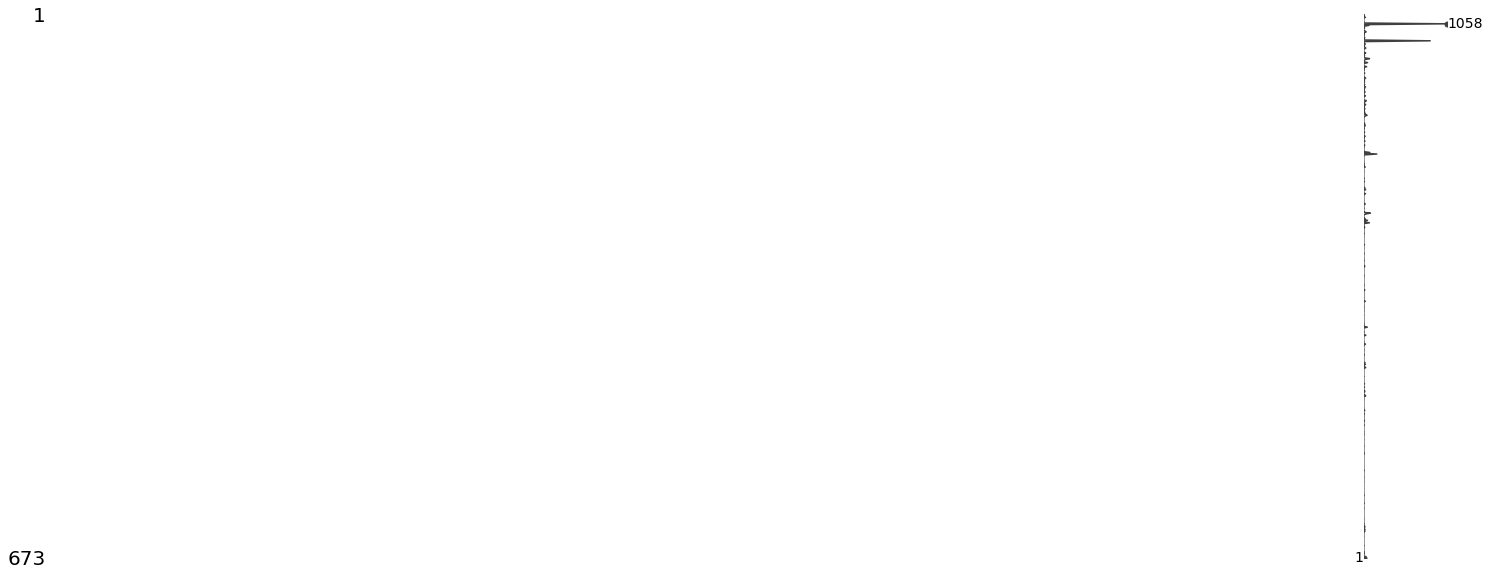

In [8]:
msno.matrix(pivot_df_m_n)

<AxesSubplot:>

<Figure size 1800x720 with 2 Axes>

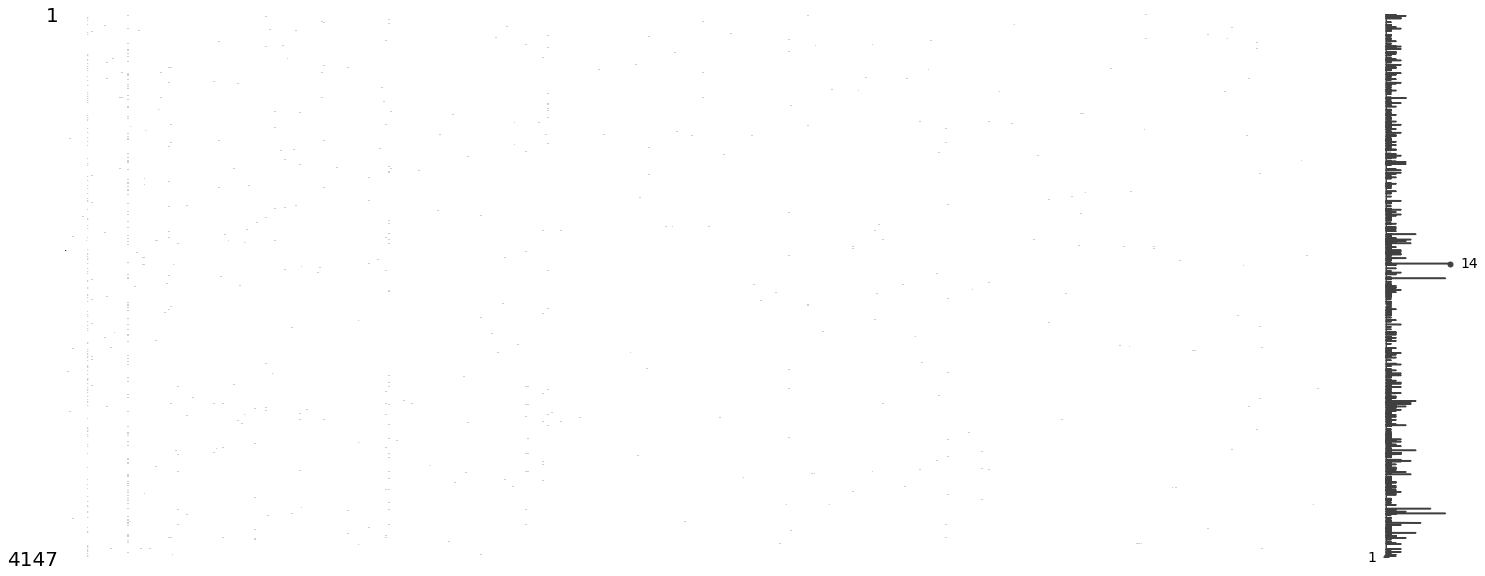

In [9]:
msno.matrix(pivot_df_n_m)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

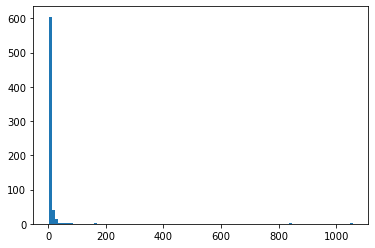

In [10]:
sub_df.groupby('CID').sum()['value'].hist(grid=False, bins=100)

<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

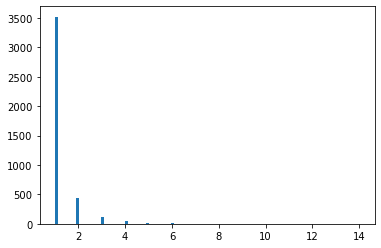

In [11]:
sub_df.groupby('uniprot_ids').sum()['value'].hist(grid=False, bins=100)

# Could we Help with Sparsity through Embedding?

In [7]:
proteins = input_df[['uniprot_ids','aa_sequence']].drop_duplicates()

In [8]:
def breakapart(word, groupsize=1, overlapsize=0): 
    brokeapart = [word[i:i+groupsize] for i in range(0, len(word), groupsize-overlapsize)]
    return [i for i in brokeapart if len(i) == groupsize]

In [9]:
sequences = [breakapart(i, groupsize=1, overlapsize=0) for i in proteins['aa_sequence'].values]

proteins['sequence'] = sequences
proteins['id'] = list(range(len(proteins)))

In [10]:
sgt = SGT(kappa=10, 
          flatten=True, 
          lengthsensitive=False,
          mode='multiprocessing')

In [11]:
#embedding = sgt.fit_transform(corpus=proteins)

In [12]:
#embedding.to_csv('protein_seq_embeddings_kappa_5_wordsize_2.tsv', sep='\t')
embedding = pd.read_csv('protein_seq_embeddings_kappa_10.tsv', sep='\t')

In [13]:
embedding.shape

(4147, 486)

In [14]:
pca = PCA(n_components=2)
pca.fit(embedding)

X = pca.transform(embedding)
print(np.sum(pca.explained_variance_ratio_))

0.9999996356501234


In [15]:
X = pd.DataFrame(X)

In [16]:
X

,0,1
0,3304.201650,-0.159479
1,3302.795550,-0.310669
2,3301.389449,-0.461946
3,3299.983348,-0.613194
4,3298.577245,-0.764460
...,...,...
4142,-3275.968097,-17.452786
4143,-3277.374199,-17.604039
4144,-3278.780299,-17.755286
4145,-3280.186401,-17.906565


<matplotlib.collections.PathCollection object at 0x7f90d92ad730>

<Figure size 1512x720 with 1 Axes>

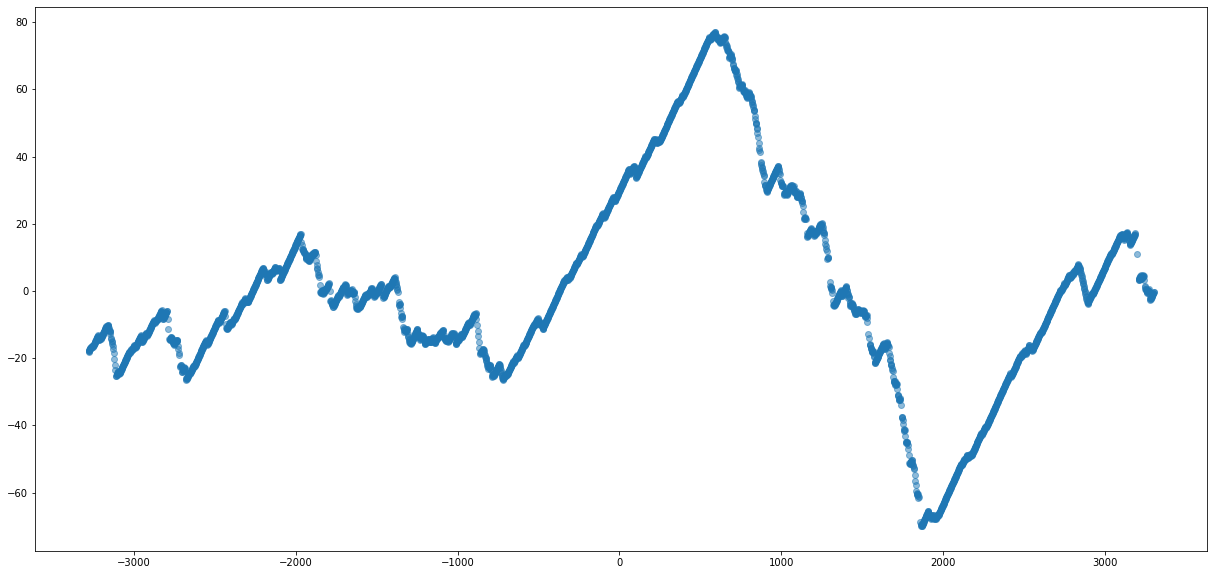

In [17]:
fig = plt.figure(figsize=(21, 10))
plt.scatter(X[0], X[1], alpha=0.5)

# This would imply that this embedding explains 99% of the variance, does that even seem reasonable?

Likely not. As we can see above, we have a lot of the protein variation explained by this but we don't really have any clustering sort of structure with this embedding. This actually makes sense though, since these "words" are really just amino acids. So, yes each protein will be different in terms of its amino acids BUT that sort of different probably isn't helpful to us.

We can try different embeddings though, how about ElMo and seqvec. This is a bit complex to install so we'll just run it in a Docker container:

```
docker pull continuumio/anaconda3

docker run -i -t -p 8888:8888 continuumio/anaconda3 /bin/bash -c "\
    conda install jupyter -y --quiet && \
    mkdir -p /opt/notebooks && \
    jupyter notebook \
    --notebook-dir=/opt/notebooks --ip='*' --port=8888 \
    --no-browser --allow-root"
   
pip insall seqvec
```

Then we'll make a multi-fasta file of the uniprot sequences and use the trained SeqVec model to create 1024-dimensional embeddings.

In [134]:
# df = pd.DataFrame(X)

# kmeans = KMeans(n_clusters=3, max_iter =300)
# kmeans.fit(df)

# labels = kmeans.predict(df)
# centroids = kmeans.cluster_centers_

In [41]:
seqRecords = []

for idx,row in input_df.iterrows():
    seqRecords.append(SeqRecord(seq=Seq(row['aa_sequence']), description='', id=row['uniprot_ids']))

In [42]:
handle = open("uniprot_records.fasta", "w")
writer = FastaWriter(handle)
writer.write_file(seqRecords)
handle.close()

In [41]:
#!wget http://maintenance.dallago.us/public/embeddings/embedding_models/seqvec/weights.hdf5 -P seqvec_items
#!wget http://maintenance.dallago.us/public/embeddings/embedding_models/seqvec/options.json -P seqvec_items

In [33]:
model_dir = Path('seqvec_items')
weights = model_dir / 'weights.hdf5' #'weights.hdf5'
options = model_dir / 'options.json'
embedder = ElmoEmbedder(options,weights, cuda_device=0)

AssertionError: Torch not compiled with CUDA enabled

In [21]:
!seqvec -i uniprot_records.fasta -o seqvec_embeddings.npz

2022-05-19 00:51:29,339 Running on the CPU
Traceback (most recent call last):
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/bin/seqvec", line 8, in <module>
    sys.exit(main())
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/lib/python3.8/site-packages/seqvec/seqvec.py", line 417, in main
    save_from_generator(emb_path, per_prot, embeddings_generator)
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/lib/python3.8/site-packages/seqvec/seqvec.py", line 252, in save_from_generator
    for sequence_id, embedding in the_generator:
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/lib/python3.8/site-packages/seqvec/seqvec.py", line 192, in get_embeddings
    seq_dict = read_fasta_file(seq_dir, split_char, id_field)
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/lib/python3.8/site-packages/seqvec/seqvec.py", line 83, in read_fasta_file
    read_fasta(seq_dict, seq_dir, split_char, id_field)
  File "/Users/pmccaffrey/anaconda3/envs/general-ds/lib/python3.8/site-packages/